In [1]:
import wandb
wandb.init(project='ChannelCharting')

W&B Run: https://app.wandb.ai/evs/ChannelCharting/runs/lsjsub0b

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [44]:
%load_ext autoreload
%autoreload 2
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append("../src")
import data_preparation
import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# read data
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")

In [5]:
#one sample example
imag_mean = np.mean(np.imag(data))
imag_std = np.std(np.imag(data))
real_mean = np.mean(np.real(data))
real_std = np.std(np.real(data))
one_sample = data[0:2,:,25:75]
one_sample_real = (np.real(one_sample) - real_mean)/real_std
one_sample_imag = (np.imag(one_sample) - imag_mean)/imag_std

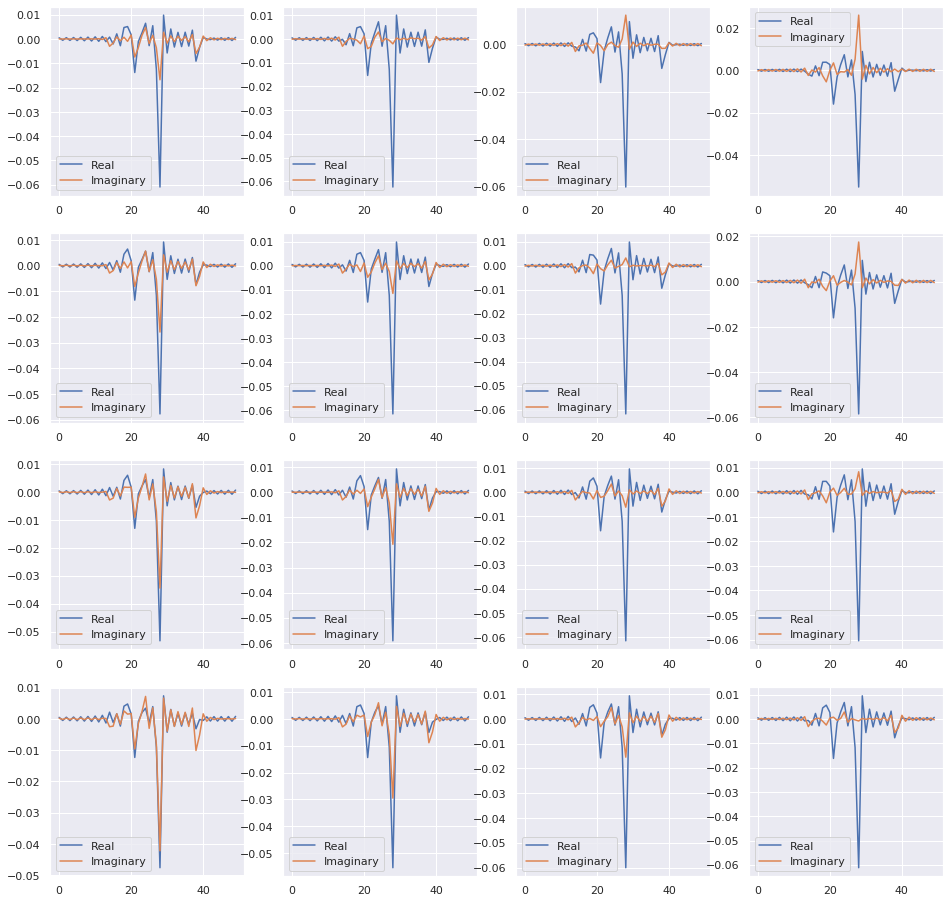

In [6]:
plt.figure(figsize=(16,16))
for i  in range(1, 17):
    plt.subplot(4,4,i)
    plt.plot(one_sample_real[0, i-1, :], label='Real')
    plt.plot(one_sample_imag[0, i-1, :], label='Imaginary')
    plt.legend()

In [7]:
one_sample_full = np.concatenate([one_sample_real, one_sample_imag], axis=0)

In [8]:
one_sample_full.shape

(4, 16, 50)

We observe that a lot of information is contained on the imaginary part of the impulse. So the 16 antennas, we are gong to have 32 'Channels' for our dataset. 
So we will have a training batch of shape [batch_size, 32 , 100].

# Siamese Neural Network

In [9]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## Setting up the Custom Dataset

In [10]:
# undersampling
idces = np.random.randint(0, data.shape[0], int(0.3*data.shape[0]))
data_undersampled = data[idces]

In [11]:
data_undersampled.shape

(7176, 16, 100)

In [12]:
data_undersampled.shape
# train test split
train, test= train_test_split(data_undersampled)

In [13]:
train_dataset = data_preparation.SiameseDataset(train)
scaler = train_dataset.scaler_real, train_dataset.scaler_imag
test_dataset = data_preparation.SiameseDataset(test, scaler)

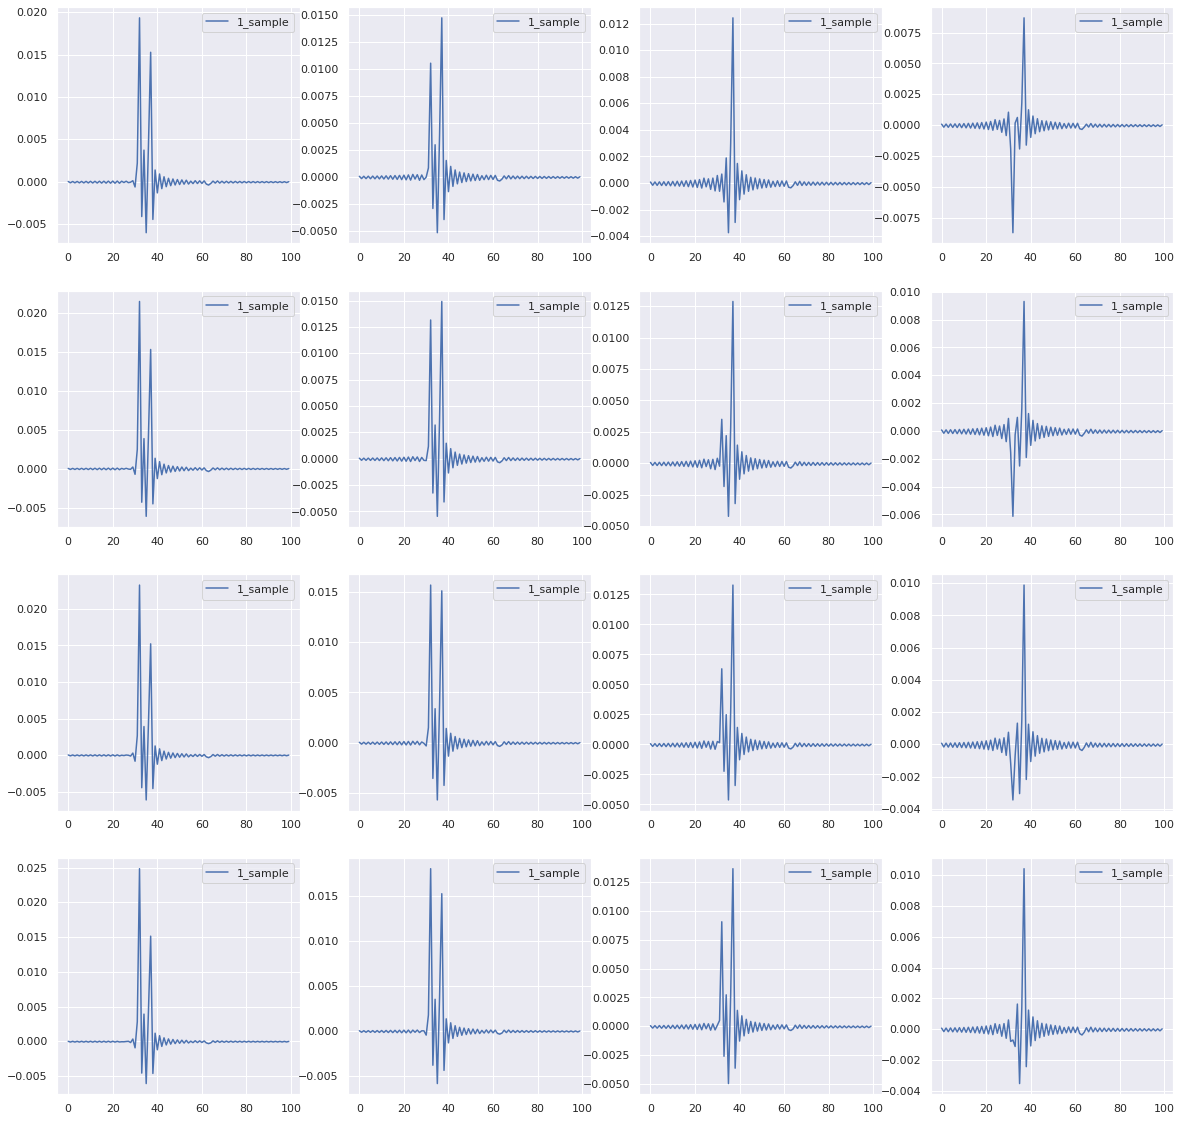

In [14]:
plt.figure(figsize=(20,20))
for i  in range(1, 17):
    plt.subplot(4,4,i)
    plt.plot(train_dataset[0][0][i-1, :], label='1_sample')
    #plt.plot(train_dataset[0][1][i-1, :], label='2_sample')
    plt.legend()

In [15]:
train_dataset.nb_channels()

32

In [16]:
class SimpleNN(nn.Module):
    def __init__(self, dropout):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=train_dataset.nb_channels(),
                          out_channels=128,
                          kernel_size=16)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(in_channels=128, 
                          out_channels=64,
                          kernel_size=8)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64,
                          out_channels=16,
                          kernel_size=4)
        self.bn3 = nn.BatchNorm1d(16)
        
        f = data_preparation.conv1d_output_size
        self.features = f(f(f(train_dataset.nb_samples(),kernel_size=16),
                                                       kernel_size=8), 
                                                         kernel_size=4)

        
        
        self.lin1 = nn.Linear(in_features= 16 * self.features, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=32)
        self.lin3 = nn.Linear(in_features=32, out_features=8)
        self.lin4 = nn.Linear(in_features=8, out_features=3)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.lin1(x)))
        x = self.dropout(F.relu(self.lin2(x)))
        x = self.dropout(F.relu(self.lin3(x)))
        
        out = self.lin4(x)
        
        return out
        
    

In [17]:
dropout = 0.3
model = SimpleNN(dropout)
wandb.watch(model)


In [18]:
def loss_function(x1, x2, y1, y2):
    return torch.sum((torch.dist(x1,x2) - torch.dist(y1, y2))**2/(torch.dist(x1,x2) + 1e-5))

In [19]:
x1, x2 = train_dataset[0:10][0], train_dataset[0:10][1]
y1, y2 = model(x1), model(x2)

## Training

In [20]:
a = len(test_dataset)/len(train_dataset)
batch_size = 16

In [21]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
criterion = loss_function
optimizer = optim.Adam(model.parameters())


In [33]:
#wandb.log({"Batch_size": batch_size,
#           "Dropout": dropout
#          })
for e in range(40):
    # train
    loss = 0
    
    for x1, x2 in train_loader:
        
        optimizer.zero_grad()
        y1, y2 = model(x1), model(x2)
        
        batch_loss = criterion(x1, x2, y1 ,y2)
        
        batch_loss.backward()
        optimizer.step()
    
        loss+=batch_loss
    
    #validation
    model.eval()
    val_loss = 0
    for x1, x2 in test_loader:
        y1, y2 = model(x1), model(x2)
        val_loss += criterion(x1, x2, y1 ,y2)
    
    wandb.log({
        "Training Loss": a*loss,
        "Validation Loss": val_loss,
    })
    print(f"Epoch {e+1}, Training Loss: {a*loss}, Validation Loss: {val_loss}")

Epoch 1, Training Loss: 334.0096740722656, Validation Loss: 496.8050231933594
Epoch 2, Training Loss: 293.8958435058594, Validation Loss: 673.7652587890625
Epoch 3, Training Loss: 144.09588623046875, Validation Loss: 302.86822509765625
Epoch 4, Training Loss: 273.3916015625, Validation Loss: 466.08135986328125
Epoch 5, Training Loss: 137.68606567382812, Validation Loss: 306.5480651855469
Epoch 6, Training Loss: 340.8561706542969, Validation Loss: 400.6341857910156
Epoch 7, Training Loss: 208.3369598388672, Validation Loss: 333.3001708984375
Epoch 8, Training Loss: 117.40669250488281, Validation Loss: 444.5162353515625
Epoch 9, Training Loss: 90.08137512207031, Validation Loss: 339.8670349121094
Epoch 10, Training Loss: 537.68310546875, Validation Loss: 1004.2998046875
Epoch 11, Training Loss: 97.94771575927734, Validation Loss: 937.2344360351562
Epoch 12, Training Loss: 149.31214904785156, Validation Loss: 276.2276306152344
Epoch 13, Training Loss: 140.1629638671875, Validation Loss: 2

## Evaluate results

In [35]:
rx_positions = np.load("../Data/RayTracingData/Remcom_4x4_rxpos.npy")

In [36]:
rx_positions

array([[   4.46871614, -159.38421631,    2.        ],
       [   6.96871614, -159.38421631,    2.        ],
       [   9.46871614, -159.38421631,    2.        ],
       ...,
       [ 464.46871614,  278.11578369,    2.        ],
       [ 466.96871614,  278.11578369,    2.        ],
       [ 469.46871614,  278.11578369,    2.        ]])

In [37]:
example_1= test_dataset[0:1][0]
example_2= test_dataset[11:12][0]

example_1.shape, example_2.shape

(torch.Size([1, 32, 100]), torch.Size([1, 32, 100]))

In [38]:
example_1_mapping, example_2_mapping = model(example_1), model(example_2)

In [39]:
example_1_mapping, example_2_mapping

(tensor([[-253.4700, -298.0238, -114.3824]], grad_fn=<AddmmBackward>),
 tensor([[-253.4700, -298.0238, -114.3824]], grad_fn=<AddmmBackward>))

In [40]:
loss_function(example_1, example_2, example_1_mapping, example_2_mapping)

tensor(0.5023, grad_fn=<SumBackward0>)

In [41]:
example_1_mapping, example_2_mapping

(tensor([[-253.4700, -298.0238, -114.3824]], grad_fn=<AddmmBackward>),
 tensor([[-253.4700, -298.0238, -114.3824]], grad_fn=<AddmmBackward>))

In [42]:
mappings = model(test_dataset[:][0]).detach().numpy()

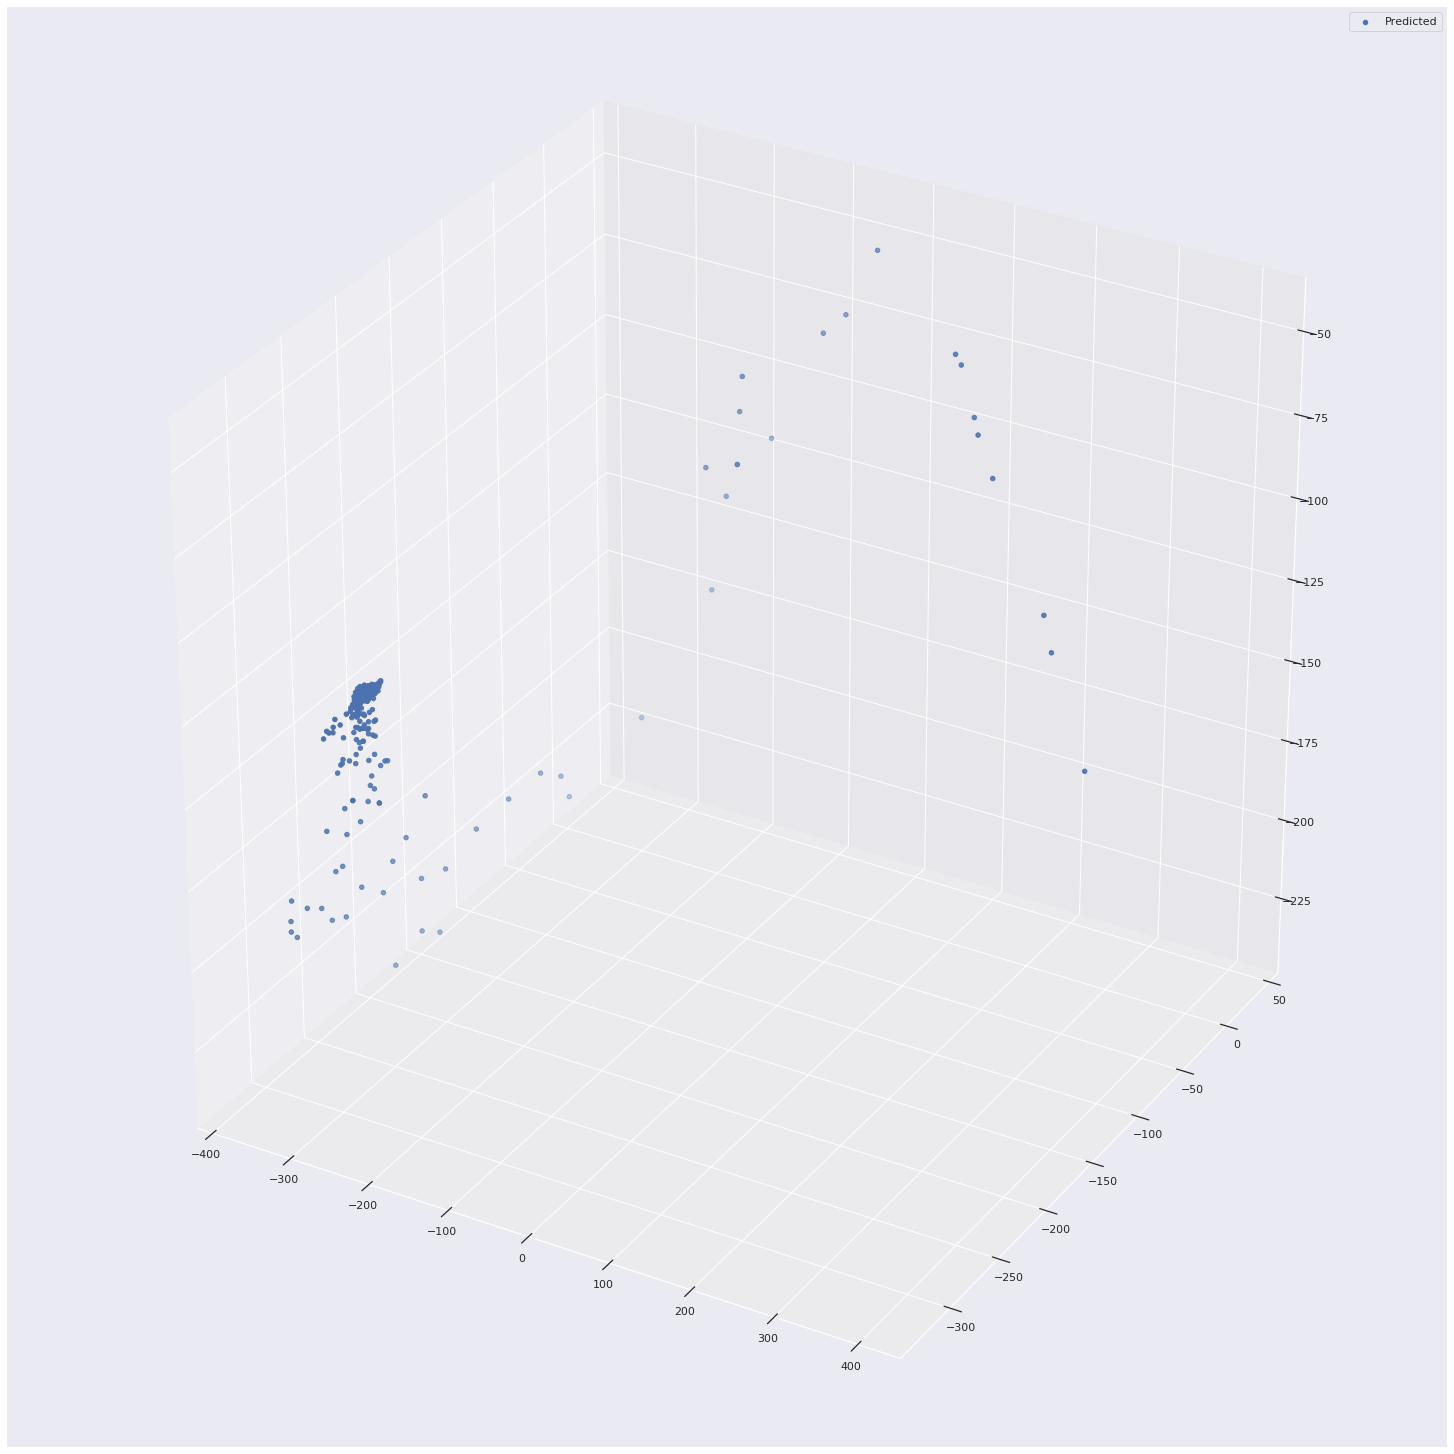

In [43]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)
ax.scatter(mappings[:,0], mappings[:,1], mappings[:,2], label='Predicted')
ax.legend()

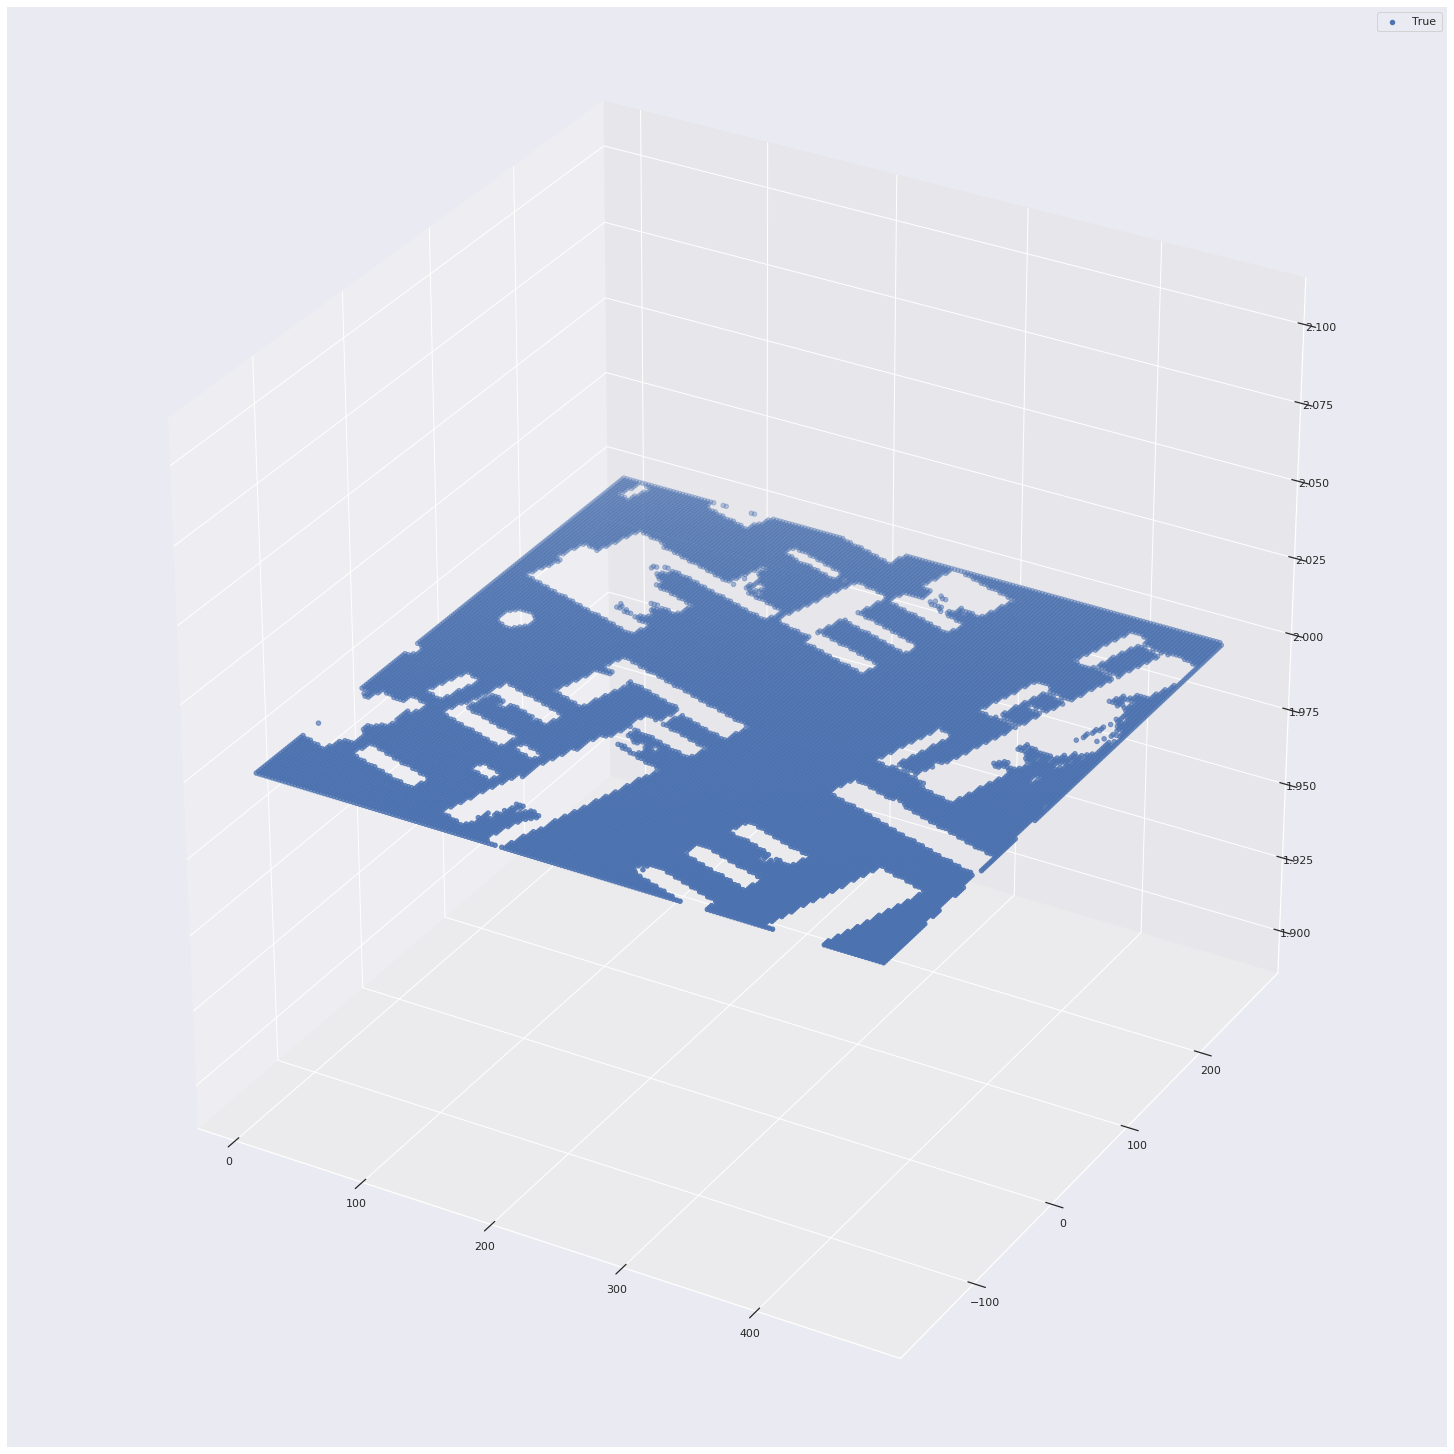

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)
ax.scatter(rx_positions[:,0], rx_positions[:,1], rx_positions[:,2], label='True')
ax.legend()

In [46]:
metrics.distance_matrix(test_dataset[:][0])

tensor([[0.0000e+00, 5.0229e-01, 3.2190e+02,  ..., 5.0271e-01, 6.9870e-01,
         5.7868e+00],
        [5.0229e-01, 0.0000e+00, 3.2190e+02,  ..., 2.2569e-02, 4.9067e-01,
         5.7733e+00],
        [3.2190e+02, 3.2190e+02, 0.0000e+00,  ..., 3.2190e+02, 3.2190e+02,
         3.2196e+02],
        ...,
        [5.0271e-01, 2.2569e-02, 3.2190e+02,  ..., 0.0000e+00, 4.9114e-01,
         5.7733e+00],
        [6.9870e-01, 4.9067e-01, 3.2190e+02,  ..., 4.9114e-01, 0.0000e+00,
         5.7938e+00],
        [5.7868e+00, 5.7733e+00, 3.2196e+02,  ..., 5.7733e+00, 5.7938e+00,
         0.0000e+00]])